In [1]:
import requests
import pandas as pd
from io import StringIO
from datetime import datetime # Kita butuh ini biar tanggalnya otomatis hari ini

# ==========================================
# 🟢 BAGIAN KONFIGURASI (UBAH DI SINI SAJA)
# ==========================================

ID_STASIUN   = '96805'  # Kode WMO (Contoh: 96805=Cilacap, 96839=YIA Kulonprogo)
RENTANG_HARI = 30       # Mau ambil data berapa hari ke belakang? (Maks 30 di Ogimet)

# Target Tanggal Akhir (Default: Hari ini/Sekarang)
# Script akan otomatis mengisi tahun(ano), bulan(mes), tanggal(day)
tgl_target = datetime.now() 

# ==========================================
# 🤖 BAGIAN PROSES (JANGAN DIUBAH)
# ==========================================

# Membangun URL secara dinamis menggunakan f-string (f"...")
url = (f"https://www.ogimet.com/cgi-bin/gsynres?lang=en&ind={ID_STASIUN}"
       f"&ndays={RENTANG_HARI}"
       f"&ano={tgl_target.year}&mes={tgl_target.month}&day={tgl_target.day}"
       f"&hora=23&ord=REV&Send=Send")

print("--- DIAGNOSA KONEKSI OGIMET (DINAMIS) ---")
print(f"📍 Stasiun ID   : {ID_STASIUN}")
print(f"📅 Rentang Data : {RENTANG_HARI} Hari ke belakang")
print(f"🔚 Sampai Tanggal: {tgl_target.strftime('%Y-%m-%d')}")
print(f"🔗 Generated URL: {url}")

# --- 1. Cek Koneksi & Download HTML ---
try:
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    response = requests.get(url, headers=headers, timeout=20)
    
    print(f"\n1. Status Code Server: {response.status_code}")
    if response.status_code == 200:
        print("✅ Koneksi Sukses! Server merespons.")
    else:
        print("❌ Gagal connect. Server menolak.")
        exit()
        
    # Cek isi teks awal
    if "No valid data found" in response.text:
        print(f"⚠️ PERINGATAN: Ogimet bilang 'No valid data found' untuk stasiun {ID_STASIUN}.")
        print("Artinya stasiun ini mungkin mati/rusak, atau ID-nya salah.")
        exit()

except Exception as e:
    print(f"❌ Error Koneksi: {e}")
    exit()

# --- 2. Cek Pembacaan Tabel (Pandas) ---
print("\n2. Mencoba Membaca Tabel...")
try:
    # Baca tabel dari HTML yang didownload
    dfs = pd.read_html(StringIO(response.text))
    print(f"✅ Berhasil! Ditemukan {len(dfs)} tabel.")
    
    # Cari tabel terbesar (biasanya itu tabel datanya)
    df_terbesar = max(dfs, key=len)
    print(f"📊 Tabel terbesar memiliki ukuran: {df_terbesar.shape} (Baris x Kolom)")
    
    if df_terbesar.shape[0] > 5:
        print("\n--- PREVIEW DATA MENTAH ---")
        print(df_terbesar.head())
        
        # Simpan ke CSV dengan nama dinamis biar gak ketukar
        nama_file = f"ogimet_{ID_STASIUN}_raw.csv"
        df_terbesar.to_csv(nama_file)
        print(f"\n✅ File tersimpan: '{nama_file}'. Silakan cek isinya!")
    else:
        print("⚠️ Tabel ditemukan tapi isinya kosong/sedikit.")

except ImportError:
    print("❌ ERROR LIBRARY: Jalankan 'pip install lxml html5lib' dulu.")
except ValueError as e:
    print(f"❌ ERROR PANDAS: Tidak ada tabel HTML yang ditemukan. ({e})")
except Exception as e:
    print(f"❌ ERROR LAIN: {e}")

--- DIAGNOSA KONEKSI OGIMET (DINAMIS) ---
📍 Stasiun ID   : 96805
📅 Rentang Data : 30 Hari ke belakang
🔚 Sampai Tanggal: 2025-11-28
🔗 Generated URL: https://www.ogimet.com/cgi-bin/gsynres?lang=en&ind=96805&ndays=30&ano=2025&mes=11&day=28&hora=23&ord=REV&Send=Send

1. Status Code Server: 200
✅ Koneksi Sukses! Server merespons.

2. Mencoba Membaca Tabel...
❌ ERROR LAIN: no text parsed from document (line 0)


In [2]:
import pandas as pd

# BACA FILE CSV
# header=1  : Lewati baris pertama (Temperature...), pakai baris kedua (Max, Min, Avg...) sebagai judul kolom.
# index_col=0 : Pakai angka urut di paling kiri sebagai index.
df = pd.read_csv('ogimet_raw_debug.csv', header=1, index_col=0)

# Cek apakah kolomnya sudah benar
df.head(10)

,Date,Max,Min,Avg,Td Avg (C),Hr. Avg (%),Dir.,Int.,Pres. s.lev (Hp),Prec. (mm),...,Sun D-1 (h),Vis Km,Daily weather summary,Daily weather summary.1,Daily weather summary.2,Daily weather summary.3,Daily weather summary.4,Daily weather summary.5,Daily weather summary.6,Daily weather summary.7
0,11/28,31.9,25.2,27.8,23.5,77.5,SSE,4.8,1010.2,2.0,...,7.0,8.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11/27,32.0,25.4,27.8,23.5,78.3,S,5.1,1009.3,Tr,...,4.4,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11/26,31.6,25.8,28.2,23.9,78.2,WSW,5.3,1008.2,3.0,...,5.5,8.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11/25,31.7,24.6,28.2,23.7,77.1,WSW,4.1,1008.8,0.0,...,8.0,8.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11/24,31.4,23.7,26.6,23.8,84.8,WSW,4.9,1009.3,55.0,...,2.6,7.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,11/23,30.5,25.6,27.6,23.8,79.8,SW,3.7,1009.1,0.0,...,10.3,8.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,11/22,29.4,24.8,26.2,24.5,91.2,W,4.5,1009.8,93.0,...,0.0,7.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,11/21,31.5,25.2,27.7,24.5,83.0,ESE,7.3,1009.0,15.0,...,6.6,8.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,11/20,31.9,24.7,27.3,24.1,82.5,S,6.4,1008.7,13.0,...,10.0,7.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,11/19,32.5,24.0,26.8,23.7,85.0,SSE,4.4,1008.6,29.0,...,7.6,7.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


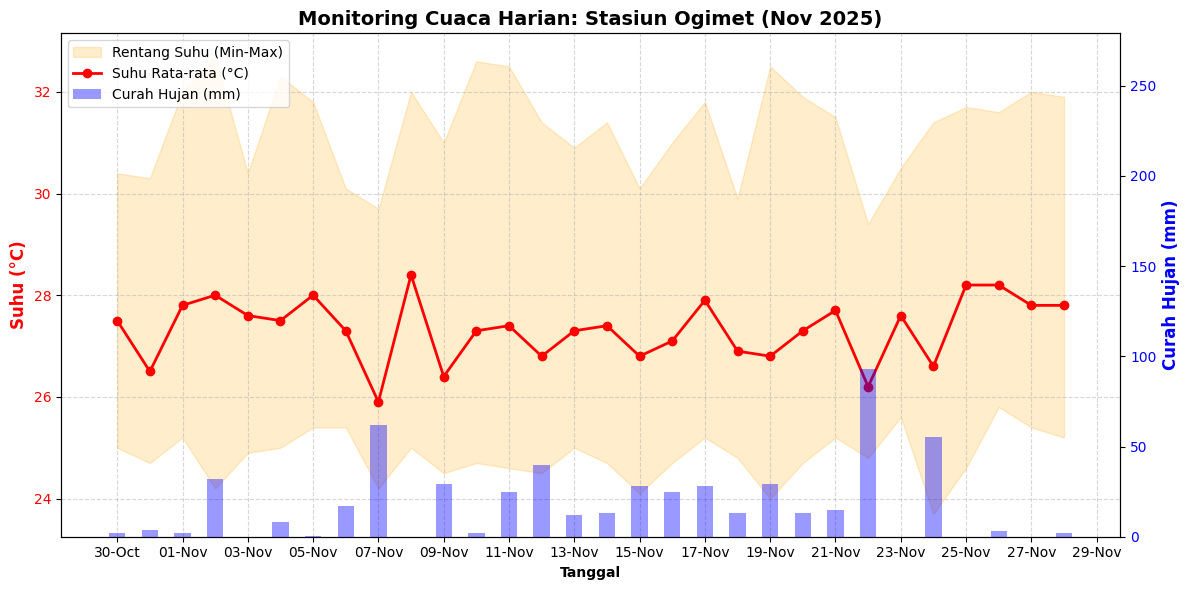

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# --- 1. BACA DATA (Sesuai cara yang benar tadi) ---
df = pd.read_csv("ogimet_raw_debug.csv", header=1, index_col=0)

# --- 2. CLEANING DATA (Wajib biar grafik gak error) ---

# A. Buang baris sampah (kalau ada header nyelip di tengah)
df = df[df['Date'] != 'Date']

# B. Perbaiki Data Hujan ('Tr' -> 0.0)
# 'Prec. (mm)' adalah nama kolom hujan di filemu
df['Prec. (mm)'] = df['Prec. (mm)'].astype(str).str.replace('Tr', '0.0')
df['Prec. (mm)'] = pd.to_numeric(df['Prec. (mm)'], errors='coerce')

# C. Pastikan Suhu jadi Angka
cols_suhu = ['Max', 'Min', 'Avg']
for col in cols_suhu:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# D. Parsing Tanggal (Format di CSV: "11/28")
# Kita tambahkan tahun 2025 biar jadi datetime lengkap
def bikin_tanggal(row):
    try:
        parts = str(row).split('/') # Pisahkan bulan dan tanggal
        bulan = int(parts[0])
        tanggal = int(parts[1])
        return pd.to_datetime(f"2025-{bulan:02d}-{tanggal:02d}")
    except:
        return pd.NaT

df['datetime'] = df['Date'].apply(bikin_tanggal)

# Set index ke tanggal & Urutkan (Penting biar garis grafik nyambung)
df = df.dropna(subset=['datetime']).set_index('datetime').sort_index()

# --- 3. PLOTTING (MEMBUAT CHART) ---
# Kita buat Combo Chart: Garis Suhu + Bar Hujan

fig, ax1 = plt.subplots(figsize=(12, 6))

# --- SUMBU KIRI (Suhu) ---
# 1. Gambar Area Range (Min sampai Max)
ax1.fill_between(df.index, df['Min'], df['Max'], 
                 color='orange', alpha=0.2, label='Rentang Suhu (Min-Max)')
# 2. Gambar Garis Rata-rata
ax1.plot(df.index, df['Avg'], 
         color='red', marker='o', linewidth=2, label='Suhu Rata-rata (°C)')

ax1.set_ylabel('Suhu (°C)', color='red', fontweight='bold', fontsize=12)
ax1.tick_params(axis='y', labelcolor='red')
ax1.grid(True, linestyle='--', alpha=0.5)

# --- SUMBU KANAN (Hujan) ---
ax2 = ax1.twinx() # Buat sumbu kembar
ax2.bar(df.index, df['Prec. (mm)'], 
        color='blue', alpha=0.4, width=0.5, label='Curah Hujan (mm)')

ax2.set_ylabel('Curah Hujan (mm)', color='blue', fontweight='bold', fontsize=12)
ax2.tick_params(axis='y', labelcolor='blue')

# Agar grafik hujan tidak menutupi grafik suhu, kita set batas atas hujan lebih tinggi
max_hujan = df['Prec. (mm)'].max()
if max_hujan > 0:
    ax2.set_ylim(0, max_hujan * 3) 

# --- FINISHING ---
ax1.set_title('Monitoring Cuaca Harian: Stasiun Ogimet (Nov 2025)', fontweight='bold', fontsize=14)
ax1.set_xlabel('Tanggal', fontweight='bold')

# Format tanggal di bawah (biar cuma tampil Tgl-Bulan)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=2)) # Tampil tiap 2 hari biar gak numpuk
plt.xticks(rotation=45)

# Gabungkan Legend (Keterangan)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()